In [20]:
from IPython.display import Image, display

import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
import numpy as np
import reddemcee

np.random.seed(1234)

# Fitting a model to data
We are going to fit a simple sinusoid model, with some white noise. This model has 4 parameters, 3 for the sinusoid plus the jitter related to the white noise:

In [8]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

theta_ = [m_true, b_true, f_true]
# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

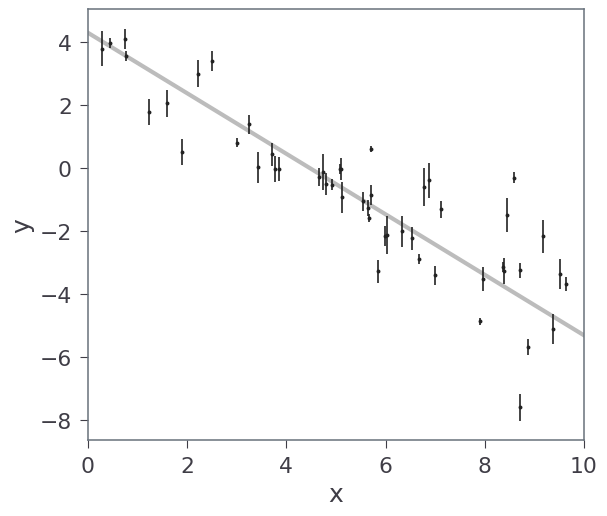

In [9]:
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
pl.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
pl.xlim(0, 10)
pl.xlabel("x")
pl.ylabel("y");

Now we need to add some error to our observations:

## Using the sampler
The sampler requires a likelihood and a prior function.

The likelihood is modeled with the residuals from the observations and the model, as well as the jitter parameter.

We will use uniform priors for every parameter.

We also need to define some limits for the prior volume, or search space:

In [16]:
def logprior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf


def loglike(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

We need to choose our sampler setup and a starting position:

In [17]:
ndim_ = 3
setup = [4, 100, 1000, 2]
ntemps, nwalkers, nsweeps, nsteps = setup

In [18]:
p0 = [theta_ + 0.1 * np.random.randn(nwalkers, ndim_) for t in range(ntemps)]

And we run the sampler:

In [43]:
sampler = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                                  logl_args=[x, y, yerr],
                                  ntemps=ntemps,
                                  betas=np.array([1., 0.22046918, 0.05614924, 0.01115874]),
                                  adaptative=False,
                                 )
    
silent = sampler.run_mcmc(p0, nsweeps, nsteps, progress=True)


100%|█████████| 2000/2000 [00:16<00:00, 119.24it/s]


In [44]:
ch = sampler.get_chains(flat=True, discard=1)
ch0 = ch[0]
theta_

[-0.9594, 4.294, 0.534]

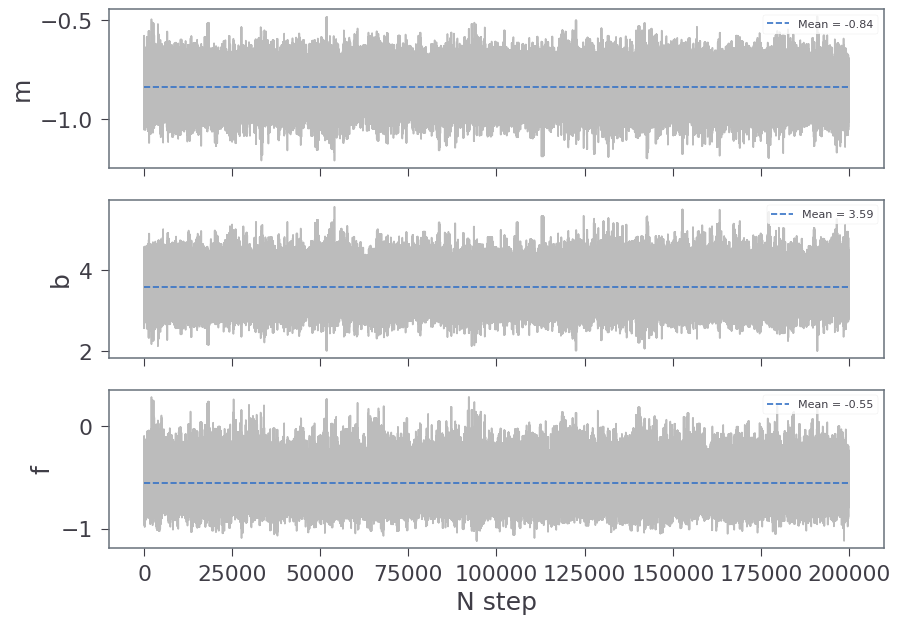

In [45]:
fig, axes = pl.subplots(ndim_, figsize=(10, 7), sharex=True)

labels = ['m', 'b', 'f']

for i in range(ndim_):
    ax = axes[i]
    chain = ch[0][:, i]
    ax.plot(chain, 'k', alpha=0.3)
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.hlines(np.mean(chain), 0, len(chain), label=f'Mean = {np.mean(chain):.2f}', ls='--')
    ax.legend(loc=1, fontsize=8)
axes[-1].set_xlabel('N step');


We discard the initial samples as burn-in, and we corner plot:

In [50]:
import corner
flat_samples = sampler.get_chains(flat=True, discard=800)[0]

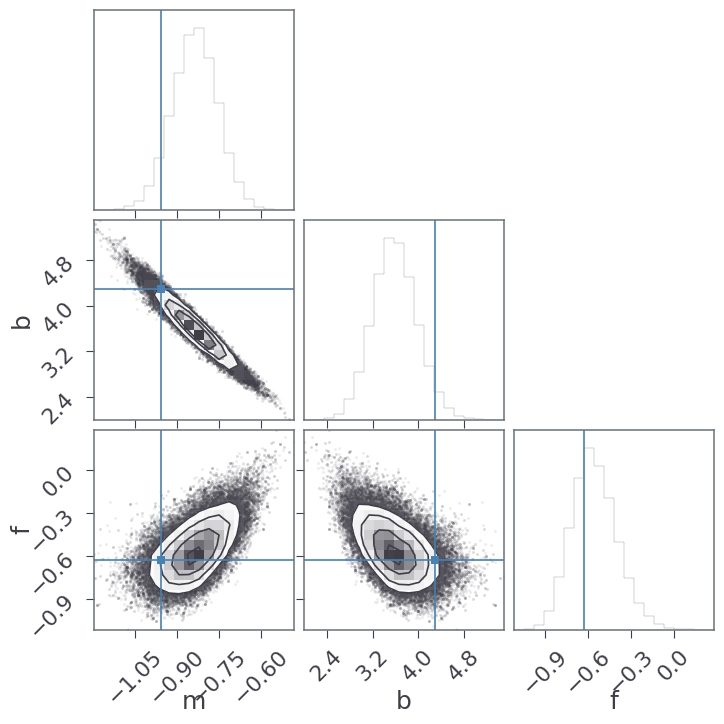

In [51]:
fig = corner.corner(flat_samples, labels=labels, truths=theta_[:2]+[np.log(theta_[-1])])

In [55]:
np.mean(ch0, axis=0)

array([-0.83605813,  3.59175228, -0.55204607])

In [98]:
np.exp(1.5)

4.4816890703380645

In [99]:
def plot_betas_ratios(sampler, setup):
    bh = sampler.betas_history
    rh = sampler.ratios_history

    fig, axes = pl.subplots(2, 1, figsize=(9, 5), sharex=True)

    bh1 = bh.reshape((setup[2], setup[0]))
    rh1 = rh.reshape((setup[2], setup[0]-1))

    for i in range(setup[0]-2):
            bh_sel = bh1[:, i]
            b = 1/np.array(bh_sel)
            axes[0].plot(np.arange(setup[2])*setup[3], b)
            axes[0].set_xscale('log')
            axes[0].set_yscale('log')


    for i in np.arange(setup[0]-1):
        r = rh1[:, i]
        axes[1].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)

    if True:
        axes[1].set_xlabel("N Step")
        axes[0].set_ylabel(r"$\beta^{-1}$")
        axes[1].set_ylabel(r"$a_{frac}$")

    pl.tight_layout()

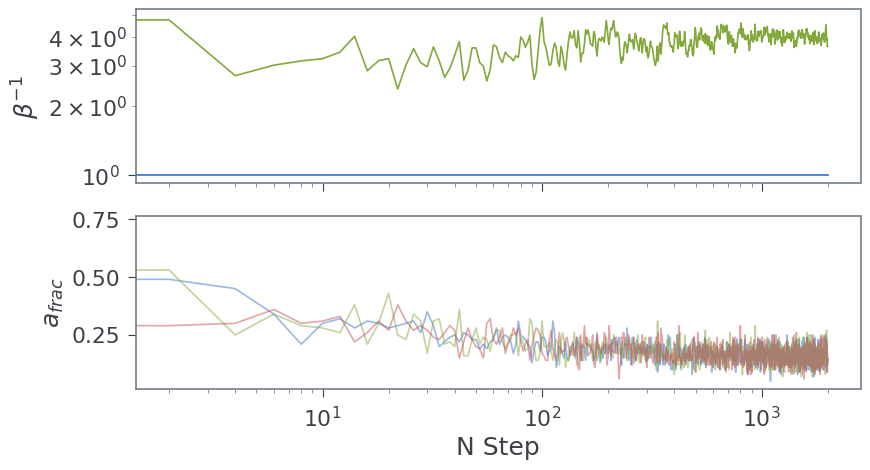

In [100]:
plot_betas_ratios(sampler, setup)

In [19]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true

In [20]:
yerr

array([0.13231625, 0.19129145, 0.23112075, 0.30557694, 0.1981231 ,
       0.44847502, 0.57148654, 0.57764205, 0.33189273, 0.50760709,
       0.23108318, 0.29824346, 0.49715752, 0.47945175, 0.3823905 ,
       0.12536203, 0.32240681, 0.51720504, 0.22990794, 0.43163732,
       0.14014101, 0.28574282, 0.36244528, 0.20605722, 0.1274708 ,
       0.54640769, 0.15491759, 0.49659627, 0.57549502, 0.55553271,
       0.12608903, 0.29444022, 0.37672944, 0.28787149, 0.54132631,
       0.3435301 , 0.25079943, 0.57230368, 0.29648333, 0.59865642,
       0.45539728, 0.42991054, 0.31715517, 0.51764772, 0.37742527,
       0.28669343, 0.49983342, 0.3410794 , 0.39300019, 0.49109217])

In [46]:
np.mean(abs(y/yerr))

8.301396304412922

In [64]:
np.mean(abs(y_/yerr_))

8.720096499544354